# Importation

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset,ConcatDataset
from tqdm.notebook import tqdm
import numpy as np

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import h5py
import wandb

from collections import Counter
import gc

In [3]:
from tqdm import tqdm

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from albumentations.core.composition import BboxParams, KeypointParams
import random
class AlbumentationsAdapter:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        return self.transform(image=img)['image']

In [5]:
___batch_size___=100
__num_workers__=4

# Chargement des données

In [6]:
df_train= pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")
df_train.head()

/tmp/ipykernel_34/2268014182.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train= pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [7]:
df_train[df_train["target"]==1]

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,ISIC_9877311,1,IP_4717387,50.0,female,posterior torso,8.16,TBP tile: close-up,3D: XP,17.351658,...,IL_8242602,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,NaN,NaN,NaN,NaN,99.197656
398671,ISIC_9941636,1,IP_7607582,60.0,female,posterior torso,5.65,TBP tile: close-up,3D: XP,21.990980,...,IL_6366837,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,99.985530
399936,ISIC_9972649,1,IP_9181133,60.0,male,lower extremity,8.51,TBP tile: close-up,3D: white,19.003400,...,IL_7739568,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,86.048290
399943,ISIC_9972877,1,IP_8877928,65.0,female,lower extremity,12.08,TBP tile: close-up,3D: white,23.465230,...,IL_7206529,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma Invasive,"Melanoma Invasive, Superficial spreading",NaN,<1/mm^2,0.6,99.786690


In [8]:
class_counts=df_train["target"].value_counts()
print(class_counts)

target
0    400666
1       393
Name: count, dtype: int64


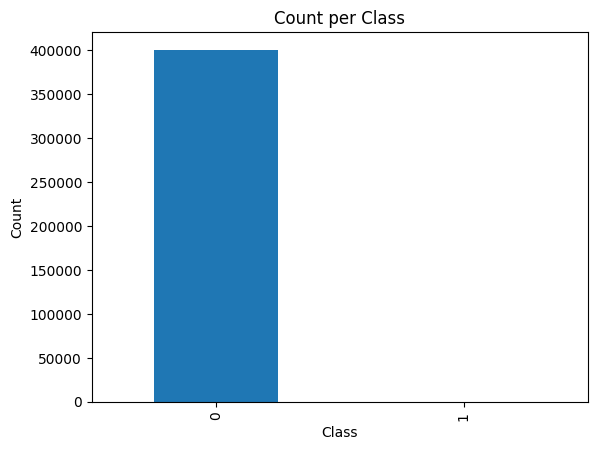

In [9]:
class_counts.plot(kind='bar')
plt.title('Count per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [10]:
train_path="/kaggle/input/isic-2024-challenge/train-image/image"
test_path="/kaggle/input/isic-2024-challenge/test-image.hdf5"
model_path="/kaggle/input/efficientnet-b0/efficient_b0_model_weight_threshold_0.25 (1).pth"

In [11]:
f = h5py.File(test_path, 'r')
f.keys() 

<KeysViewHDF5 ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']>

In [12]:
from PIL import Image
import io

def hdf5_dataset_key_to_image(hdf5_file,key) :
    dataset=hdf5_file[key]
    data=dataset[()]
    image=Image.open(io.BytesIO(data))
    return np.array(image)

[[[123  73  48]
  [117  67  42]
  [113  63  38]
  ...
  [137  85  61]
  [137  85  61]
  [136  84  60]]

 [[124  74  49]
  [119  69  44]
  [117  67  42]
  ...
  [130  78  54]
  [132  80  56]
  [132  80  56]]

 [[125  75  50]
  [122  72  47]
  [121  71  46]
  ...
  [130  78  54]
  [134  82  58]
  [135  83  59]]

 ...

 [[114  68  44]
  [111  65  39]
  [110  64  40]
  ...
  [125  73  49]
  [122  70  46]
  [119  67  45]]

 [[113  67  44]
  [110  64  40]
  [110  64  41]
  ...
  [114  67  41]
  [111  64  38]
  [109  61  38]]

 [[115  68  48]
  [116  70  47]
  [119  72  52]
  ...
  [104  60  35]
  [107  63  38]
  [111  69  45]]]


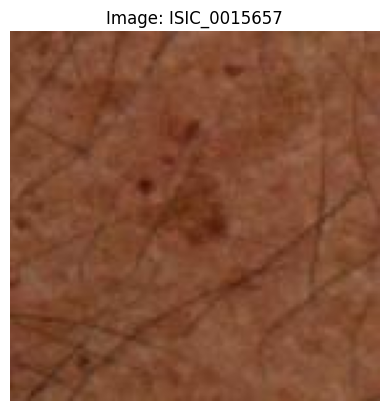

In [13]:
print(hdf5_dataset_key_to_image(f,list(f.keys())[0]))
plt.imshow(hdf5_dataset_key_to_image(f,list(f.keys())[0]))
plt.title(f'Image: {list(f.keys())[0]}')
plt.axis('off')
plt.show()

In [14]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, df_train, transform=None):
        self.root_dir = root_dir
        self.target_dict = df_train.set_index('isic_id')['target'].to_dict()
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.label_to_index = {'benign': 0, 'malignant': 1}
        self.index_to_label = ['benign', 'malignant']
        self.minor_class_datas=[]
        # Charger les chemins d'images et les étiquettes
        self._get_img_paths()

    def _get_img_paths(self):
        entries = list(os.scandir(self.root_dir))
        total_files = len(entries)
        
        for entry in tqdm(entries, desc="Loading images...", total=total_files, dynamic_ncols=True, leave=True):
            if entry.is_file() and entry.name.endswith(('.jpg', '.jpeg', '.png')):
                img_name = entry.name.replace(".jpg", "")
                self.img_paths.append(entry.path)
                target=int(self.target_dict[img_name])
                self.labels.append(target)
                if target==1 :
                    self.minor_class_datas.append((entry.path,target))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
    
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[idx]
        return image, label

In [15]:
# utilisons la classe ImageFolder afin de charger le train set
dataset = ImageDataset(train_path, df_train,  transform=AlbumentationsAdapter(A.Compose([
    A.Resize(224, 224),
    ToTensorV2(),
])))

# la classe ImageFolder assigne automatiquement un label pour chaque nom de classe (class -> idx)
print('class -> idx : ',dataset.label_to_index)

# on aura besoin d'un dictionnaire qui fait le sens inverse (idx -> class)
idx_to_class = {dataset.label_to_index[class_name]: class_name for class_name in  dataset.label_to_index}
print('idx -> class : ',idx_to_class)

Loading images...: 100%|██████████| 401059/401059 [08:29<00:00, 787.44it/s]

class -> idx :  {'benign': 0, 'malignant': 1}
idx -> class :  {0: 'benign', 1: 'malignant'}


tensor([[[165, 165, 164,  ..., 166, 164, 163],
         [164, 164, 163,  ..., 165, 163, 162],
         [164, 163, 163,  ..., 163, 161, 160],
         ...,
         [146, 145, 144,  ..., 148, 148, 148],
         [145, 145, 145,  ..., 148, 148, 148],
         [145, 145, 146,  ..., 148, 148, 148]],

        [[122, 121, 121,  ..., 120, 118, 117],
         [121, 121, 120,  ..., 119, 117, 116],
         [121, 120, 120,  ..., 117, 115, 114],
         ...,
         [101, 100,  99,  ..., 102, 102, 102],
         [101, 101, 101,  ..., 102, 102, 102],
         [101, 101, 102,  ..., 102, 102, 102]],

        [[ 87,  86,  86,  ...,  86,  83,  81],
         [ 87,  86,  85,  ...,  85,  82,  80],
         [ 86,  85,  85,  ...,  83,  80,  78],
         ...,
         [ 72,  71,  70,  ...,  68,  68,  68],
         [ 72,  72,  72,  ...,  68,  68,  68],
         [ 72,  72,  73,  ...,  68,  68,  68]]], dtype=torch.uint8)


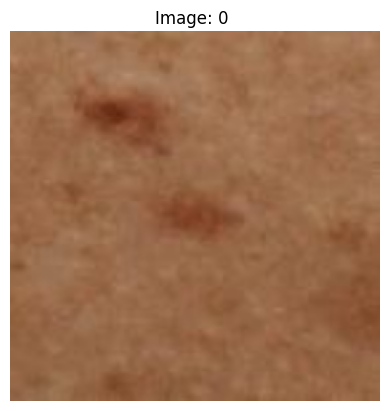

In [16]:
for x,y in dataset:
    print(x)
    plt.imshow(x.permute(1,2,0))
    plt.title(f'Image: {y} ')
    plt.axis('off')
    plt.show()
    break

## Equibrage du dataset par rapport aux classes

In [17]:
import torch
from torch.utils.data import DataLoader

def get_mean_and_std(dataset):
    """
    Calcule la moyenne et l'écart type des canaux de l'ensemble de données d'images à une dimension.

    Args:
    dataset (torch.utils.data.Dataset): Dataset pour calculer la moyenne et l'écart type.

    Returns:
    tuple: Moyenne et écart type des canaux de l'ensemble de données.
    """
    loader = DataLoader(dataset, batch_size=1,num_workers=__num_workers__, shuffle=False)
    
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    loader_tqdm = tqdm(loader, desc=f'Calcul des params de normalisation...', leave=True)
    for data in loader_tqdm :
        inputs, c = data  # Extraction des données et étiquettes
        inputs = inputs.squeeze().float()  # Suppression de la dimension du lot
        channels_sum += torch.mean(inputs, dim=0)
        channels_squared_sum += torch.mean(inputs**2, dim=0)
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

In [18]:
# mean,std= get_mean_and_std(dataset)

In [19]:
# Trouver la classe majoritaire et le nombre d'instances à atteindre
class_images = dataset.minor_class_datas
print('Class min counts:', len(class_images))

Class min counts: 393


In [20]:
print('Class min counts:', len(class_images))

Class min counts: 393


In [21]:
class CustomDatasetWithNames(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [22]:
def augment_classes(custumDataloader, class_counts, device, batch_size=200, deficit=1000):
    image_count = 0
    pbar = tqdm(total=deficit, desc="Augmenting classes")

    augmented_images = []
    augmented_labels = []

    while image_count < deficit:
        for images, labels in custumDataloader:
            if image_count >= deficit:
                break

            for image, label in zip(images, labels):
                if image_count >= deficit:
                    break
                image_np = image  # Convert image to numpy array
                augmented_images.append(image_np)
                augmented_labels.append(label)  # Convert label to numpy array
                image_count += 1
                pbar.update(1)

                if len(augmented_images) >= batch_size or image_count >= deficit:
                    augmented_images_tensor = torch.tensor(np.stack(augmented_images)).to(device)
                    augmented_labels_tensor = torch.tensor(np.stack(augmented_labels)).to(device)

                    yield augmented_images_tensor, augmented_labels_tensor
                    augmented_images = []
                    augmented_labels = []

                    gc.collect()
                    torch.cuda.empty_cache()

    pbar.close()

# Function to create augmented dataset
def create_augmented_dataset(custumDataloader, class_counts, device, dataset, batch_size=32, deficit=1000):
    all_augmented_images = []
    all_augmented_labels = []

    for images, labels in augment_classes(custumDataloader, class_counts, device, batch_size, deficit):
        all_augmented_images.append(images.cpu())  # Move images to CPU
        all_augmented_labels.append(labels.cpu())  # Move labels to CPU

    # Concatenate along the first dimension (batch dimension)
    all_augmented_images = torch.cat(all_augmented_images, dim=0)
    all_augmented_labels = torch.cat(all_augmented_labels, dim=0)

    print(f"Augmented dataset size: {len(all_augmented_images)} images, {len(all_augmented_labels)} labels")
    augmented_dataset = CustomDatasetWithNames(images=all_augmented_images, labels=all_augmented_labels,transform=None)

    all_augmented_images = []
    all_augmented_labels = []
    gc.collect()
    torch.cuda.empty_cache()
    return augmented_dataset


# Obtenir le device GPU disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [23]:
def get_random_params():
    return {
        "rotate_limit": random.randint(20, 60),
        "alpha": random.uniform(80, 160),
        "sigma": random.uniform(10, 20),
        "alpha_affine": random.uniform(0.02, 0.04),
        "var_limit": (random.uniform(5.0, 20.0), random.uniform(20.0, 50.0)),
    }

params = get_random_params()

augment_transform = AlbumentationsAdapter(A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Rotate(limit=params["rotate_limit"], p=0.5),
    A.ElasticTransform(alpha=params["alpha"], sigma=params["sigma"], alpha_affine=params["alpha_affine"], p=0.5),
    A.GridDistortion(p=0.5),
    A.GaussNoise(var_limit=params["var_limit"], p=0.5),
    ToTensorV2(),
]))



In [24]:
class custumDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path,label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(np.array(image))
        return image,label
    
custumDataset = custumDataset(images=class_images, transform=augment_transform)
custumDataloader = DataLoader(custumDataset, batch_size=___batch_size___, shuffle=True, num_workers=__num_workers__,pin_memory=True)

# Préparation de dataset

In [25]:
class Cutout(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        h, w = img.size()[1], img.size()[2]
        mask_size_half = self.mask_size // 2

        cxmin, cxmax = mask_size_half, w - mask_size_half
        cymin, cymax = mask_size_half, h - mask_size_half

        if cxmin >= cxmax or cymin >= cymax:
            return img
        
        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half
        ymin, ymax = cy - mask_size_half, cy + mask_size_half

        img[:, ymin:ymax, xmin:xmax] = 0
        return img

In [26]:
class ConvertCHWtoHWC(A.ImageOnlyTransform):
    def apply(self, img, **params):
        return np.transpose(img, (1, 2, 0)) if img.shape[0] in [1, 3] else img

train_transform = AlbumentationsAdapter(A.Compose([
    # Assurez-vous que les dimensions sont appropriées pour vos spectrogrammes si nécessaire
    ConvertCHWtoHWC(always_apply=True),
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=40, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
    A.GaussianBlur(blur_limit=7, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.ChannelShuffle(p=0.5),
    A.CLAHE(clip_limit=2, p=0.5),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, p=0.5),
    A.RandomRain(drop_length=5, drop_width=1, rain_type='drizzle', p=0.5),
    #A.Normalize(mean=mean.tolist(), std=std.tolist(), always_apply=True),
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2(),
    
]))

test_transform = AlbumentationsAdapter(A.Compose([
    # Assurez-vous que les dimensions sont appropriées pour vos spectrogrammes si nécessaire
    ConvertCHWtoHWC(always_apply=True),
        A.Resize(224, 224),
    #A.Normalize(mean=mean.tolist(), std=std.tolist(), always_apply=True),
    ToTensorV2(),
    
]))

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [27]:
# Division des indices pour l'entraînement, la validation et le test
np.random.seed(42)
indices = np.arange(len(dataset))
np.random.shuffle(indices)
num_train = int(0.1* len(indices))
num_val = int(0.09 * len(indices))
num_test= int(0.1 * len(indices))

train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val: num_train + num_val+num_test]

In [28]:
from torch.utils.data import Dataset

class TransformingSubset(Dataset):
    def __init__(self, subset, transform=None):
        """
        subset: Un objet Subset de PyTorch contenant les indices et le dataset original.
        transform: Les transformations à appliquer aux éléments du dataset.
        """
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # Récupérer l'élément depuis le subset
        x, y = self.subset[index]

        # Appliquer les transformations
        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.subset)

In [29]:
from torch.utils.data import Subset

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

# Créer les instances de TransformingSubset
train_dataset = TransformingSubset(train_subset, transform=None)

valid_dataset = TransformingSubset(val_subset, transform=None)
custum_test_dataset = TransformingSubset(test_subset, transform=None)

In [30]:
len(train_dataset),len(valid_dataset),len(custum_test_dataset)

(40105, 36095, 40105)

In [31]:
augmented_dataset_train = create_augmented_dataset(custumDataloader, class_counts, None, dataset, batch_size=___batch_size___,deficit=20000)

Augmenting classes: 100%|██████████| 20000/20000 [02:58<00:00, 111.86it/s]


Augmented dataset size: 20000 images, 20000 labels


In [32]:
augmented_dataset_valid = create_augmented_dataset(custumDataloader, class_counts, None, dataset, batch_size=___batch_size___,deficit=15000)

Augmenting classes: 100%|██████████| 15000/15000 [02:26<00:00, 102.33it/s]


Augmented dataset size: 15000 images, 15000 labels


In [33]:
augmented_dataset_test = create_augmented_dataset(custumDataloader, class_counts, None, dataset, batch_size=___batch_size___,deficit=14500)

Augmenting classes: 100%|██████████| 14500/14500 [02:21<00:00, 102.21it/s]


Augmented dataset size: 14500 images, 14500 labels


In [34]:
class CustomTransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image=np.array(image)
        if self.transform:
            image = self.transform(image)  
        image = image / 255.0
        return image, label

In [35]:
balanced_train_dataset=CustomTransformDataset(dataset=ConcatDataset([train_dataset, augmented_dataset_train]),transform=train_transform)
balanced_valid_dataset=CustomTransformDataset(dataset=ConcatDataset([valid_dataset, augmented_dataset_valid]),transform=test_transform)
balanced_test_dataset=CustomTransformDataset(dataset=ConcatDataset([custum_test_dataset, augmented_dataset_test]),transform=test_transform)

54605
tensor([[[0.7098, 0.7176, 0.7294,  ..., 0.6078, 0.6275, 0.6431],
         [0.7098, 0.7176, 0.7294,  ..., 0.6118, 0.6353, 0.6471],
         [0.7176, 0.7216, 0.7333,  ..., 0.6196, 0.6431, 0.6588],
         ...,
         [0.7176, 0.7216, 0.7294,  ..., 0.6941, 0.7020, 0.7098],
         [0.7216, 0.7216, 0.7255,  ..., 0.6941, 0.7059, 0.7137],
         [0.7255, 0.7216, 0.7216,  ..., 0.6980, 0.7059, 0.7137]],

        [[0.4627, 0.4706, 0.4824,  ..., 0.3608, 0.3804, 0.3961],
         [0.4627, 0.4706, 0.4824,  ..., 0.3647, 0.3882, 0.4000],
         [0.4706, 0.4745, 0.4863,  ..., 0.3725, 0.3961, 0.4118],
         ...,
         [0.4706, 0.4745, 0.4824,  ..., 0.4510, 0.4588, 0.4667],
         [0.4784, 0.4784, 0.4824,  ..., 0.4510, 0.4627, 0.4706],
         [0.4824, 0.4784, 0.4784,  ..., 0.4549, 0.4627, 0.4706]],

        [[0.4039, 0.4118, 0.4235,  ..., 0.2902, 0.3176, 0.3294],
         [0.4078, 0.4118, 0.4235,  ..., 0.2980, 0.3216, 0.3333],
         [0.4118, 0.4157, 0.4275,  ..., 0.3059, 0.33

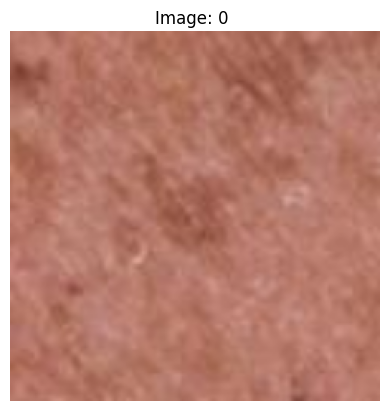

In [36]:
def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

print(len(balanced_test_dataset))
for x,y in balanced_test_dataset:
    print(x)
          
    plt.imshow(x.permute(1,2,0))
    plt.title(f'Image: {y} ')
    plt.axis('off')
    plt.show()
    break
    


# Création du modele 

In [37]:
model= timm.create_model('efficientnet_b2', pretrained=True)
#
model.classifier = nn.Linear(model.classifier.in_features, 1)
#model.load_state_dict(torch.load("/kaggle/working/efficient_b1_model_weight_threshold_0.25.pth"))

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

if torch.cuda.device_count() > 1:
    print("Utilisons", torch.cuda.device_count(), "GPUs !")
    model = torch.nn.DataParallel(model)


model = model.to(device)

Using cuda device
Utilisons 2 GPUs !


In [39]:
torch.cuda.empty_cache()

In [40]:
from sklearn.metrics import roc_curve, auc

def compute_partial_auc(y_true, y_scores, min_tpr=0.80):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    max_fpr = abs(1 - min_tpr)

    if max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

# Exemple d'utilisation
# y_true : Vérités terrain (labels) binaires
# y_scores : Scores prédits par le modèle
y_true = [0, 0, 1, 1]  # Exemple
y_scores = [0.1, 0.4, 0.35, 0.8]  # Exemple

pauc = compute_partial_auc(y_true, y_scores, min_tpr=0.8)
print(f"Partial AUC above 80% TPR: {pauc}")


Partial AUC above 80% TPR: 0.09999999999999998


In [41]:
wandb.login(key="2fe9c387b7df54598064a08dcb406b496c34a32b")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [42]:
from sklearn.metrics import f1_score

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=5, growth_threshold=1, threshold=0.5):
    # Initialiser Weights & Biases
    wandb.init(project="Detection de cancer de peau (suivi)",
               config={
    "Author": "Betchaleel",
    "architecture": "efficientnet_b1",
    "dataset": "Skin cancer dataset",
    "threshold": threshold,
    "initial_learning_rate": optimizer.param_groups[0]['lr'],
    "epochs": num_epochs,
    "initial_weight_decay": optimizer.param_groups[0]['weight_decay'],
    "train_dataset_length": len(train_dataset),
    "valid_dataset_length": len(valid_dataset),
    "test_dataset_length": len(custum_test_dataset),
    "augment_train_dataset_length": len(augmented_dataset_train),
    "augment_valid_dataset_length": len(augmented_dataset_valid),
    "augment_test_dataset_length": len(augmented_dataset_test),
    "current_learning_rate": optimizer.param_groups[0]['lr'],
    "current_weight_decay": optimizer.param_groups[0]['weight_decay'],
    "patience": patience,
    "growth_threshold": growth_threshold,
    "batch_size": ___batch_size___
})
    epochs_since_adjustment = 0
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_pAUC': [],
        'train_f1': [],  # Ajouter le F1-score à l’historique
        'val_loss': [],
        'val_accuracy': [],
        'val_pAUC': [],  # Ajouter la pAUC à l’historique
        'val_f1': []  # Ajouter le F1-score à l’historique
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs_since_adjustment = 0  # Nouvelle variable pour suivre le nombre d'epochs depuis la dernière mise à jour des hyperparamètres

    previous_train_pAUC = 0
    previous_val_pAUC = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss_items = []
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_outputs = []
        train_tqdm = tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=False)
        for images, labels in train_tqdm:
            assert isinstance(images, torch.Tensor), f"Expected images to be a tensor but got {type(images)}"
            assert isinstance(labels, torch.Tensor), f"Expected labels to be a tensor but got {type(labels)}"

            images, labels = images.to(device).float(), labels.to(device).unsqueeze(1).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss_items.append(loss.item())
            predicted = (outputs > threshold).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_train_labels.extend(labels.cpu().numpy())
            all_train_outputs.extend(outputs.detach().cpu().numpy())  # Utiliser detach() pour convertir en numpy
            gc.collect()
            torch.cuda.empty_cache()

        avg_train_loss = sum(train_loss_items) / len(train_loss_items)
        train_accuracy = 100 * correct_train / total_train
        train_pAUC = compute_partial_auc(np.array(all_train_labels), np.array(all_train_outputs))
        train_f1 = f1_score(np.array(all_train_labels), (np.array(all_train_outputs) > 0.25).astype(float))
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_pAUC'].append(train_pAUC)
        history['train_f1'].append(train_f1)

        # Log training metrics to Weights & Biases
        wandb.log({'Loss/Train': avg_train_loss,
                   'Accuracy/Train': train_accuracy,
                   'pAUC/Train': train_pAUC,
                   'F1/Train': train_f1,
                   'Learning Rate': optimizer.param_groups[0]['lr'],
                   'Weight Decay': optimizer.param_groups[0]['weight_decay'],
                   'epoch': epoch})
        
        # Validation phase
        model.eval()
        val_loss_items = []
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_outputs = []
        val_tqdm = tqdm(val_loader, desc='Validating', leave=False)
        with torch.no_grad():
            for images, labels in val_tqdm:
             
                images, labels = images.to(device).float(), labels.to(device).unsqueeze(1).float()
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_items.append(loss.item())
                
                predicted = (outputs > threshold).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_outputs.extend(outputs.detach().cpu().numpy())  # Utiliser detach() pour convertir en numpy
                gc.collect()
                torch.cuda.empty_cache()

        avg_val_loss = sum(val_loss_items) / len(val_loss_items)
        val_accuracy = 100 * correct_val / total_val
        val_pAUC = compute_partial_auc(np.array(all_val_labels), np.array(all_val_outputs))
        val_f1 = f1_score(np.array(all_val_labels), (np.array(all_val_outputs) > 0.5).astype(float))
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_pAUC'].append(val_pAUC)
        history['val_f1'].append(val_f1)

        # Log validation metrics to Weights & Biases
        wandb.log({'Loss/Validation': avg_val_loss,
                   'Accuracy/Validation': val_accuracy,
                   'pAUC/Validation': val_pAUC,
                   'F1/Validation': val_f1,
                   'Learning Rate': optimizer.param_groups[0]['lr'],
                   'Weight Decay': optimizer.param_groups[0]['weight_decay'],
                   'epoch': epoch})
        
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training pAUC: {train_pAUC:.4f}, Training F1: {train_f1:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation pAUC: {val_pAUC:.4f}, Validation F1: {val_f1:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']}, Weight Decay: {optimizer.param_groups[0]['weight_decay']}")

        # Calculate growth rates
        train_pAUC_growth = train_pAUC - previous_train_pAUC
        val_pAUC_growth = val_pAUC - previous_val_pAUC

        # Detect overfitting and adjust learning rate and weight decay
        epochs_since_adjustment += 1
        if epochs_since_adjustment > 4:  # Check if it's been 4 epochs since last adjustment
            if (avg_val_loss >= best_val_loss and train_pAUC > val_pAUC) or \
               (train_pAUC_growth > (1 + growth_threshold) * val_pAUC_growth):
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.8
                    param_group['weight_decay'] *= 1.5
                print(f"Adjusted learning rate to {optimizer.param_groups[0]['lr']} and weight decay to {optimizer.param_groups[0]['weight_decay']} due to overfitting.")
                epochs_since_adjustment = 0  # Reset epochs_since_adjustment after adjustment

        # Update previous pAUCs
        previous_train_pAUC = train_pAUC
        previous_val_pAUC = val_pAUC

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return history


In [43]:
criterion = nn.BCEWithLogitsLoss()
initial_weight_decay=1e-5
initial_learning_rate=1e-4
optimizer=torch.optim.AdamW(model.parameters(), lr=initial_learning_rate, weight_decay=initial_weight_decay) #meilleur config jusqu'a present

In [44]:
threshold=0.25
num_epochs=10

In [45]:
train_loader = DataLoader(balanced_train_dataset, batch_size=___batch_size___, shuffle=True,num_workers=4, collate_fn=custom_collate_fn,pin_memory=True)
val_loader = DataLoader(balanced_valid_dataset, batch_size=___batch_size___, shuffle=False,num_workers=4, collate_fn=custom_collate_fn,pin_memory=True)

In [46]:
history=train_and_validate(model, train_loader, val_loader, criterion, optimizer,threshold=threshold,num_epochs=num_epochs)

wandb: Currently logged in as: bbsanakinao (betch). Use `wandb login --relogin` to force relogin


RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/timm/models/efficientnet.py", line 259, in forward
    x = self.forward_features(x)
  File "/opt/conda/lib/python3.10/site-packages/timm/models/efficientnet.py", line 247, in forward_features
    x = self.blocks(x)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/timm/models/_efficientnet_blocks.py", line 182, in forward
    x = self.conv_dw(x)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 460, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 456, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training and Validation"):
    """
    Trace les courbes de perte, de précision, de pAUC et de F1-score pour les ensembles d'entraînement et de validation en utilisant l'objet history.

    Args:
    history: Un dictionnaire contenant les clés 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy',
             'train_pAUC', 'val_pAUC', 'train_f1', et 'val_f1' qui mappent à des listes des valeurs correspondantes à travers les époques.
    title (str): Titre du graphique.
    """
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    train_pAUC = history['train_pAUC']
    val_pAUC = history['val_pAUC']
    train_f1 = history['train_f1']
    val_f1 = history['val_f1']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(28, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_pAUC, 'bo-', label='Training pAUC')
    plt.plot(epochs, val_pAUC, 'ro-', label='Validation pAUC')
    plt.title(title + ' - pAUC')
    plt.xlabel('Epochs')
    plt.ylabel('pAUC')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_f1, 'bo-', label='Training F1')
    plt.plot(epochs, val_f1, 'ro-', label='Validation F1')
    plt.title(title + ' - F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig("tmp.png")
    plt.show()
    
    wandb.log({"trainning_plot": wandb.Image("tmp.png")})


In [ ]:
plot_training_history(history)

In [ ]:
# import os
# os.remove('/kaggle/working/efficient_model_weights_99_threshold_0.5.pth')

In [ ]:
if torch.cuda.device_count() > 1:
    torch.save(model.module.state_dict(), f"/kaggle/working/efficient_b1_model_weight_threshold_{threshold}.pth")
else:
    torch.save(model.state_dict(), f"/kaggle/working/efficient_b1_model_weight_threshold_{threshold}.pth")

# Inférence Test

In [50]:
# on aura besoin d'un dataloader qui enveloppe notre objet test_dataset
custum_test_loader = DataLoader(balanced_test_dataset, batch_size=100, shuffle=True, num_workers=6, collate_fn=custom_collate_fn,pin_memory=True) 

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(
    f"""
    Train dataset lenght :{len(train_dataset)} 
    Valid dataset lenght : {len(valid_dataset)} 
    Test dataset lenght : {len(custum_test_dataset)} 
    Augment Train dataset lenght :{len(augmented_dataset_train)} 
    Augment Valid dataset lenght : {len(augmented_dataset_valid)} 
    Augment Test dataset lenght : {len(augmented_dataset_test)} 
    initial_learning_rate : {initial_learning_rate}
    initial_weight_decay : {initial_weight_decay}
    learning_rate : {optimizer.param_groups[0]['lr']}
    weight_decay : {optimizer.param_groups[0]['weight_decay']}
    threshold: {threshold}
    num_epoch: {num_epochs}
    """
)


In [48]:
thresholds=[0.25,0.5,0.75]
y_preds = []
y_trues = []

In [51]:
from torch.utils.data import DataLoader

for threshold in thresholds:
    print(f"Threshold : {threshold}")
    # Phase de test
    model.eval()
    y_pred = []
    y_true = []
    val_loss_items = []
    correct_val = 0
    total_val = 0

    val_tqdm = tqdm(custum_test_loader, desc='Test', leave=False)

    with torch.no_grad():
        for images, labels in val_tqdm:
            # Envoyer les images et les étiquettes au GPU
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_items.append(loss.item())

            # Utiliser sigmoid pour obtenir les probabilités et convertir en prédictions binaires
            outputs = torch.sigmoid(outputs)
            predicted = (outputs > threshold).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            current_val_accuracy = 100 * correct_val / total_val

            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

            val_tqdm.set_postfix(loss=loss.item(), accuracy=f'{current_val_accuracy:.2f}%')
            gc.collect()
            torch.cuda.empty_cache()

    avg_val_loss = sum(val_loss_items) / len(val_loss_items)
    val_pAUC = compute_partial_auc(np.array(y_true), np.array(y_pred))
    f1 = f1_score(y_true, (np.array(y_pred) > threshold).astype(int))
    y_preds.append(y_pred)
    y_trues.append(y_true)
            
    
    # Afficher le résultat
    print(f'Test Loss: {avg_val_loss:.4f}, Test Accuracy: {current_val_accuracy:.2f}%, Test pAUC: {val_pAUC:.4f}, Test F1-score: {f1:.4f} \n')

Threshold : 0.25


RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(conf_matrix,threshold):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.title(f'Matrice de Confusion with threshold {threshold}')
    plt.savefig("tmp.png")
    plt.show()
    
    wandb.log({"trainning_plot": wandb.Image("tmp.png")})

In [ ]:
from sklearn.metrics import confusion_matrix

for idx, threshold in enumerate(thresholds): 
    y_pred_binary = np.array(y_preds[idx]) > threshold

    conf_matrix = confusion_matrix(y_trues[idx], y_pred_binary)
    show_confusion_matrix(conf_matrix,threshold)

In [ ]:
    wandb.finish()

# Inference Final

In [ ]:
class CustomTransformDataset(Dataset):
    def __init__(self, test_path, transform=None):
        self.hdf5_files= h5py.File(test_path, 'r')
        self.indices=list(self.hdf5_files.keys())
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx=self.indices[idx]
        dataset= self.hdf5_files[actual_idx]
        data=dataset[()]
        image=np.array(Image.open(io.BytesIO(data)))
        if self.transform:
            image = self.transform(image)            
        return image,actual_idx

In [ ]:
# on aura besoin d'un dataloader qui enveloppe notre objet test_dataset
test_dataset=CustomTransformDataset(test_path,transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=___batch_size___, shuffle=True, num_workers=__num_workers__) # souvent le shuffle est mis a False, mais avec notre implementation, ca marche dans tous les cas

In [ ]:
print(len(test_dataset))
for x,y in test_loader:
    print(y)
          
    plt.imshow(x[0].permute(1,2,0))
    plt.title(f'Image: {y[0]} ')
    plt.axis('off')
    plt.show()
    break
    


In [ ]:
model.to(device)
model.eval()

predicted = []
image_names = []

for batch, labels in test_loader:
    images = batch.to(device)
    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # Convertir les sorties en prédictions binaires
        #predicted = (outputs > 0.5).float().cpu().numpy()
        #print(predicted)
        predicted.extend(outputs.float().cpu().numpy())
        gc.collect()
        torch.cuda.empty_cache()
    # Stocker les labels cibles
    image_names.extend(labels)

assert len(image_names) == len(predicted), f"Mismatch in length: {len(image_names)} targets vs {len(predicted)} predictions"
print(f'Il y a {len(predicted)} exemples de test')


In [ ]:
predicted=[x[0] for x in predicted]
predictions_df = pd.DataFrame(data=zip(image_names, predicted), columns=['isic_id', 'target'])
predictions_df

In [ ]:
predictions_df.to_csv('submission.csv', index=False)